In [32]:
import torch
import faiss
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

import time
from contextlib import contextmanager
import re

from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
from langchain_groq import ChatGroq

In [2]:
@contextmanager
def timer(name, timings):
    start = time.perf_counter()
    yield
    end = time.perf_counter()
    timings[name] = timings.get(name, 0.0) + (end - start)


In [4]:
qa_model_name = "alex-apostolo/legal-bert-base-cuad"

qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name).cuda()
qa_model.eval()

embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [5]:
index = faiss.read_index(
    r"C:\Users\sengu\agentic\legal_agent\vectore_db\eurlex_mpnet.index"
)

chunks_df = pd.read_parquet(
    r"C:\Users\sengu\agentic\legal_agent\vectore_db\eurlex_chunks.parquet"
)


In [7]:
def chunk_contract(
    text,
    tokenizer,
    max_tokens=400,
    overlap=50
):
    """
    Returns a list of text chunks, each <= max_tokens,
    with token overlap to avoid boundary loss.
    """
    tokens = tokenizer(
        text,
        return_offsets_mapping=True,
        add_special_tokens=False
    )

    input_ids = tokens["input_ids"]
    offsets = tokens["offset_mapping"]

    chunks = []
    start = 0

    while start < len(input_ids):
        end = min(start + max_tokens, len(input_ids))

        char_start = offsets[start][0]
        char_end = offsets[end - 1][1]

        chunk_text = text[char_start:char_end]
        chunks.append(chunk_text)

        start += max_tokens - overlap

    return chunks

def cache_cuad_questions(tokenizer, schema, device="cuda"):
    questions = list(schema.values())

    q_tokens = tokenizer(
        questions,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
        add_special_tokens=True
    )

    q_tokens = {k: v.to(device) for k, v in q_tokens.items()}

    return {
        "labels": list(schema.keys()),
        "questions": questions,
        "q_tokens": q_tokens
    }


In [8]:
def qa_based_classification_batched_optimized(
    model,
    tokenizer,
    context,
    cached_questions,
    device="cuda",
    max_answer_len=50,
    top_k=20
):
    timings = {}
    t0 = time.time()

    labels = cached_questions["labels"]
    q_tokens = cached_questions["q_tokens"]
    num_labels = len(labels)

    # --- Tokenize context ONCE ---
    t1 = time.time()
    context_tokens = tokenizer(
        context,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        add_special_tokens=True
    ).to(device)
    timings["tokenization"] = time.time() - t1

    # --- Build batched inputs ---
    t2 = time.time()
    input_ids = []
    attention_masks = []

    for i in range(num_labels):
        ids = torch.cat([
            q_tokens["input_ids"][i],
            context_tokens["input_ids"][0][1:]  # skip CLS
        ])[:512]

        mask = torch.ones_like(ids)

        input_ids.append(ids)
        attention_masks.append(mask)

    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)

    timings["input_build"] = time.time() - t2

    # --- Forward pass (single GPU call) ---
    t3 = time.time()
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_masks
        )
    timings["forward"] = time.time() - t3

    # --- Optimized span search ---
    t4 = time.time()
    results = {}

    for i, label in enumerate(labels):
        start_logits = outputs.start_logits[i]
        end_logits = outputs.end_logits[i]

        start_logits[0] = -1e9
        end_logits[0] = -1e9

        top_s = torch.topk(start_logits, top_k)
        top_e = torch.topk(end_logits, top_k)

        best_score = -1e9
        best_span = None

        for s_idx, s_score in zip(top_s.indices, top_s.values):
            for e_idx, e_score in zip(top_e.indices, top_e.values):
                if e_idx < s_idx:
                    continue
                if e_idx - s_idx > max_answer_len:
                    continue

                score = s_score + e_score
                if score > best_score:
                    best_score = score
                    best_span = (s_idx.item(), e_idx.item())

        if best_span:
            answer = tokenizer.decode(
                input_ids[i][best_span[0]:best_span[1]+1],
                skip_special_tokens=True
            )
        else:
            answer = ""

        if len(answer.split()) >= 6 and best_score > 5.0:
            results[label] = {
                "present": True,
                "text": answer,
                "confidence": float(best_score)
            }
        else:
            results[label] = {
                "present": False,
                "text": None,
                "confidence": float(best_score)
            }

    timings["span_search"] = time.time() - t4
    timings["total"] = time.time() - t0

    return results, timings


In [10]:
def run_contract_analysis_sequential(
    chunks,
    model,
    tokenizer,
    cached_questions,
    device="cuda"
):
    all_results = []
    timing_stats = []

    for i, chunk in enumerate(chunks):
        qa_results, timings = qa_based_classification_batched_optimized(
            model=model,
            tokenizer=tokenizer,
            context=chunk,
            cached_questions=cached_questions,
            device=device
        )

        timing_stats.append(timings)

        for label, res in qa_results.items():
            if not res["present"]:
                continue

            all_results.append({
                "chunk_id": i,
                "label": label,
                "confidence": res["confidence"],
                "span": res["text"]
            })

    return all_results, timing_stats

In [18]:
def filter_clause_extractions(
    clause_results,
    min_confidence=7.5,
    min_span_words=None
):
    """
    Filters clause extraction results based on confidence and span length.

    Args:
        clause_results (list[dict]): Output of contract analysis.
        min_confidence (float): Minimum confidence to keep a clause.
        min_span_words (int | None): Minimum number of words in span.
                                     If None, span-length filtering is disabled.

    Returns:
        list[dict]: Filtered clause results.
    """

    filtered = []

    for r in clause_results:
        # Confidence check
        if r["confidence"] < min_confidence:
            continue

        # Optional span-length check
        if min_span_words is not None:
            span = r.get("span")
            if not span or len(span.split()) < min_span_words:
                continue

        filtered.append(r)

    return filtered

In [21]:
def build_eurlex_query(label, span_text):
    return (
        f"EU law and regulations concerning {label.lower()} clauses in contracts. "
        f"Relevant provisions regarding: {span_text}"
    )



def retrieve_eurlex(query: str, k: int = 5):
    q_emb = embedder.encode(
        [query],
        normalize_embeddings=True
    )

    scores, indices = index.search(q_emb, k)

    results = []
    for score, idx in zip(scores[0], indices[0]):
        row = chunks_df.iloc[idx]
        results.append({
            "celex_id": row["celex_id"],
            "title": row["title"],
            "text": row["text"],
            "eurovoc_concepts": row["eurovoc_concepts"],
            "score": float(score),
        })

    return results


def extract_eurlex_evidence_parallel(
    filtered_results,
    retrieve_fn,
    k=5,
    max_workers=None
):
    """
    Parallel EUR-Lex retrieval for clause instances.
    """

    if max_workers is None:
        # FAISS + embedding = do NOT use all cores
        max_workers = min(8, os.cpu_count())

    records = []

    def process_clause(r):
        label = r["label"]
        span = r["span"]
        confidence = r["confidence"]
        chunk_id = r["chunk_id"]

        query = build_eurlex_query(label, span)
        hits = retrieve_fn(query, k=k)

        rows = []
        for rank, hit in enumerate(hits, start=1):
            rows.append({
                "chunk_id": chunk_id,
                "label": label,
                "confidence": confidence,
                "span": span,
                "query": query,

                "rank": rank,
                "celex_id": hit["celex_id"],
                "title": hit["title"],
                "eurlex_text": hit["text"],
                "eurovoc_concepts": hit["eurovoc_concepts"],
                "similarity_score": hit["score"],
            })
        return rows

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_clause, r)
            for r in filtered_results
        ]

        for future in tqdm(as_completed(futures), total=len(futures), desc="EUR-Lex retrieval"):
            records.extend(future.result())

    return pd.DataFrame(records)


In [11]:
CUAD_QA_SCHEMA = {
    "Assignment": "Does this contract specify an assignment clause?",
    "Anti-Assignment": "Does this contract restrict assignment?",
    "Change of Control": "Does this contract specify a change of control clause?",
    "Subcontracting": "Does this contract specify a subcontracting clause?",
    "Third Party Beneficiaries": "Does this contract specify third party beneficiaries?",
    "Joint and Several Liability": "Does this contract specify joint and several liability?",

    "Termination for Convenience": "Does this contract specify a termination for convenience clause?",
    "Termination for Cause": "Does this contract specify a termination for cause clause?",
    "Contract Duration": "Does this contract specify a contract duration?",
    "Renewal Term": "Does this contract specify a renewal term?",
    "Notice Period": "Does this contract specify a notice period?",

    "Limitation of Liability": "Does this contract specify a limitation of liability?",
    "Cap on Liability": "Does this contract specify a cap on liability?",
    "Consequential Damages": "Does this contract exclude consequential damages?",
    "Liquidated Damages": "Does this contract specify liquidated damages?",
    "Indemnification": "Does this contract specify an indemnification clause?",
    "Covenant Not To Sue": "Does this contract specify a covenant not to sue?",

    "Confidentiality": "Does this contract specify a confidentiality clause?",
    "Return of Materials": "Does this contract specify a return of materials clause?",
    "Data Protection": "Does this contract specify a data protection clause?",

    "Intellectual Property": "Does this contract specify intellectual property ownership?",

    "Governing Law": "Does this contract specify a governing law?",
    "Dispute Resolution": "Does this contract specify a dispute resolution clause?",

    "Compliance with Laws": "Does this contract specify compliance with laws?",
    "Insurance": "Does this contract specify insurance requirements?",
    "Audits": "Does this contract specify audit rights?",

    "Payment Terms": "Does this contract specify payment terms?",
    "Performance Standards": "Does this contract specify performance standards?",
    "Most Favoured Nation": "Does this contract include a most favoured nation clause?",

    "Non Compete": "Does this contract include a non-compete clause?",
    "Non Disparagement": "Does this contract include a non-disparagement clause?",
    "Exclusivity": "Does this contract specify exclusivity?",
    "Restrictive Covenants": "Does this contract specify restrictive covenants?",
    "Anti-Embarrassment": "Does this contract include an anti-embarrassment clause?",

    "Force Majeure": "Does this contract specify a force majeure clause?",
    "Waiver": "Does this contract specify a waiver clause?",
    "Severability": "Does this contract specify a severability clause?",
    "Representations and Warranties": "Does this contract specify representations and warranties?",
    "Right of First Refusal": "Does this contract specify a right of first refusal?",
    "Anti-Sandbagging": "Does this contract include an anti-sandbagging clause?",
    "Anti-Assignment (Narrow)": "Does this contract include a narrowly tailored anti-assignment clause?"
}



In [12]:
# Load contract
with open(
    r"C:\Users\sengu\agentic\legal_agent\sec-edgar-filings\MSFT\10-K\0000950170-25-100235\EX-10.8.txt",
    "r",
    encoding="utf-8",
    errors="ignore"
) as f:
    contract_text = f.read()

In [13]:
# Cache CUAD questions once
cached_questions = cache_cuad_questions(
    qa_tokenizer,
    CUAD_QA_SCHEMA
)


In [14]:
# Chunk contract
chunks = chunk_contract(
    contract_text,
    qa_tokenizer,
    max_tokens=400,
    overlap=50
)

print(f"Contract chunked into {len(chunks)} segments.")

Token indices sequence length is longer than the specified maximum sequence length for this model (16696 > 512). Running this sequence through the model will result in indexing errors


Contract chunked into 48 segments.


In [15]:
chunk_id = 8
test_chunk = chunks[chunk_id]

start = time.time()

qa_results, timings = qa_based_classification_batched_optimized(
    model=qa_model,
    tokenizer=qa_tokenizer,
    context=test_chunk,
    cached_questions=cached_questions,
    device="cuda"
)

end = time.time()

print(f"Chunk {chunk_id} processed in {end - start:.2f}s")
print("Timings:", timings)


Chunk 8 processed in 6.82s
Timings: {'tokenization': 0.8685388565063477, 'input_build': 0.11293458938598633, 'forward': 2.28794527053833, 'span_search': 3.5498733520507812, 'total': 6.819292068481445}


In [16]:
results, timings = run_contract_analysis_sequential(
    chunks,
    qa_model,
    qa_tokenizer,
    cached_questions,
)

print(f"Extracted {len(results)} clause instances")

Extracted 1333 clause instances


In [19]:
filtered_results = filter_clause_extractions(
    results,
    min_confidence=8.5,
    min_span_words=30
)

print(f"Filtered down to {len(filtered_results)} clause instances")

Filtered down to 586 clause instances


In [22]:
eurlex_df = extract_eurlex_evidence_parallel(
    filtered_results=filtered_results,
    retrieve_fn=retrieve_eurlex,
    k=5,
    max_workers=os.cpu_count()
)

print(f"Total EUR-Lex rows: {len(eurlex_df)}")


EUR-Lex retrieval: 100%|██████████| 586/586 [00:28<00:00, 20.60it/s]


Total EUR-Lex rows: 2930


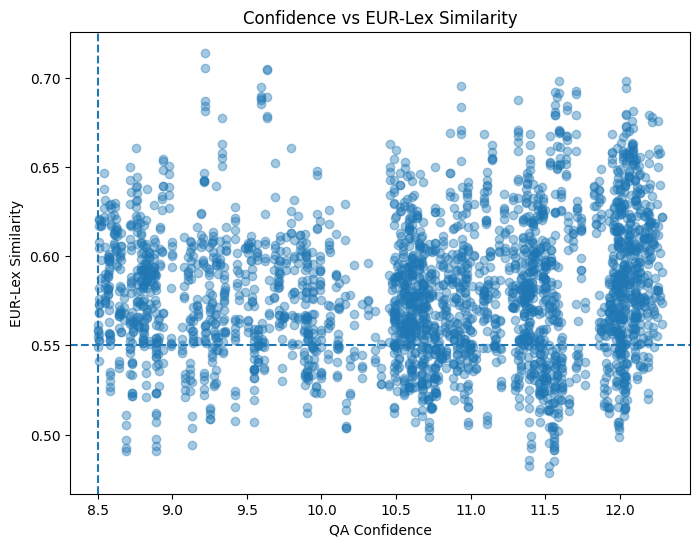

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(
    eurlex_df["confidence"],
    eurlex_df["similarity_score"],
    alpha=0.4
)

plt.axhline(0.55, linestyle="--")
plt.axvline(8.5, linestyle="--")

plt.xlabel("QA Confidence")
plt.ylabel("EUR-Lex Similarity")
plt.title("Confidence vs EUR-Lex Similarity")

plt.show()


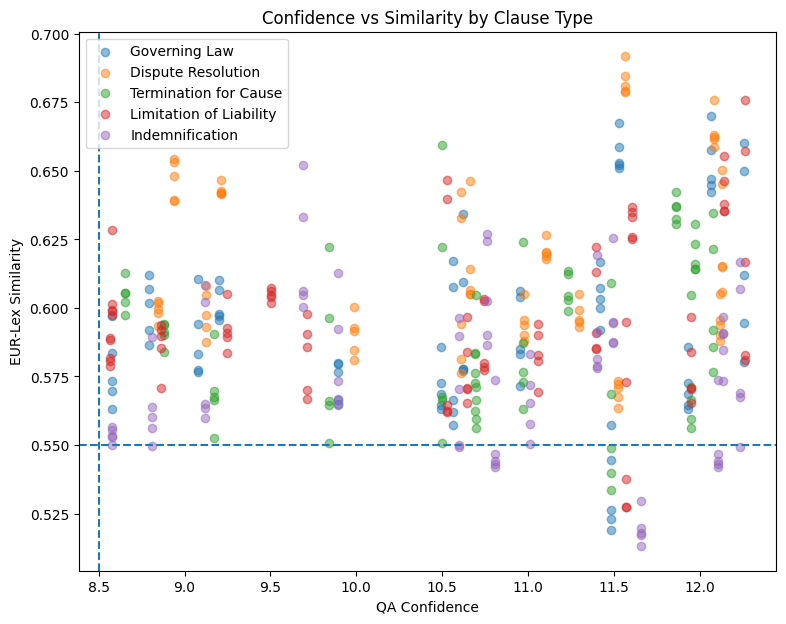

In [25]:
labels_to_plot = [
    "Governing Law",
    "Dispute Resolution",
    "Termination for Cause",
    "Limitation of Liability",
    "Indemnification"
]

plt.figure(figsize=(9, 7))

for label in labels_to_plot:
    sub = eurlex_df[eurlex_df["label"] == label]
    plt.scatter(
        sub["confidence"],
        sub["similarity_score"],
        label=label,
        alpha=0.5
    )

plt.axhline(0.55, linestyle="--")
plt.axvline(8.5, linestyle="--")

plt.xlabel("QA Confidence")
plt.ylabel("EUR-Lex Similarity")
plt.title("Confidence vs Similarity by Clause Type")
plt.legend()
plt.show()


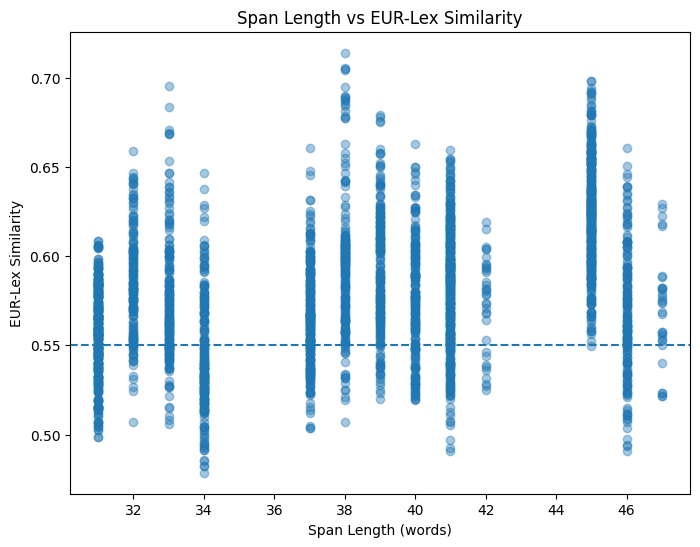

In [26]:
eurlex_df["span_len"] = eurlex_df["span"].str.split().apply(len)

plt.figure(figsize=(8, 6))
plt.scatter(
    eurlex_df["span_len"],
    eurlex_df["similarity_score"],
    alpha=0.4
)

plt.axhline(0.55, linestyle="--")
plt.xlabel("Span Length (words)")
plt.ylabel("EUR-Lex Similarity")
plt.title("Span Length vs EUR-Lex Similarity")
plt.show()


In [34]:
def make_clause_id(row):
    return f"chunk{row['chunk_id']}::{row['label']}"


def group_eurlex_by_clause(eurlex_df):
    grouped = {}

    for _, row in eurlex_df.iterrows():
        clause_id = make_clause_id(row)

        if clause_id not in grouped:
            grouped[clause_id] = {
                "chunk_id": row["chunk_id"],
                "label": row["label"],
                "span": row["span"],
                "confidence": row["confidence"],
                "span_len": row["span_len"],
                "evidence": []
            }

        grouped[clause_id]["evidence"].append({
            "celex_id": row["celex_id"],
            "title": row["title"],
            "text": row["eurlex_text"],
            "similarity": row["similarity_score"],
            "rank": row["rank"]
        })

    return grouped


def build_reasoning_input(
    clause_obj,
    max_docs=5,
    max_chars_per_doc=1200
):
    evidence = sorted(
        clause_obj["evidence"],
        key=lambda x: x["similarity"],
        reverse=True
    )[:max_docs]

    law_blocks = []
    for ev in evidence:
        law_blocks.append(
            f"[CELEX {ev['celex_id']} – {ev['title']}]\n"
            f"{ev['text']}"
        )

    return {
        "label": clause_obj["label"],
        "span": clause_obj["span"],
        "confidence": clause_obj["confidence"],
        "law_text": "\n\n".join(law_blocks)
    }



from langchain_core.messages import SystemMessage, HumanMessage
import json

SYSTEM_PROMPT = """You are a legal reasoning assistant specialized in EU contract law.

Rules:
- Use ONLY the provided EU legal texts.
- If applicability is unclear, say so explicitly.
- Do NOT invent law.
- Be conservative and precise.
"""

def run_llm_reasoning(llm, grouped_clauses):
    outputs = []

    for clause_id, clause_obj in grouped_clauses.items():
        inp = build_reasoning_input(clause_obj)

        prompt = f"""
Contract clause (type: {inp['label']}):
\"\"\"
{inp['span']}
\"\"\"

Relevant EU legal texts:
\"\"\"
{inp['law_text']}
\"\"\"

Respond ONLY in valid JSON:
{{
  "clause_interpretation": "...",
  "eu_law_applicability": "Yes | No | Unclear",
  "compliance_assessment": "Compliant | Conditional | Likely Non-Compliant",
  "justification": "...",
  "risk_notes": "..."
}}
"""

        messages = [
            SystemMessage(content=SYSTEM_PROMPT),
            HumanMessage(content=prompt)
        ]

        response = llm.invoke(messages).content

        outputs.append({
            "clause_id": clause_id,
            "chunk_id": clause_obj["chunk_id"],
            "label": clause_obj["label"],
            "confidence": clause_obj["confidence"],
            "span_len": clause_obj["span_len"],
            "span": clause_obj["span"],
            "llm_raw_output": response
        })

    return outputs

def clean_missing_text(text):
    # remove text before the json data starts (either starts with json after removing false values: or json )
    # first_output_removed = re.sub(r".*final_missing_json:", "json", text, flags=re.dotall)
    
    # remove the trailing and any newlines, then strip leading/trailing whitespace
    final_output = re.sub(r"```json|```|\n", "", text).strip()
    
    # remove any unwanted text after the closing bracket ]
    final_output = re.sub(r"\](-.)?$", "]", final_output)
    
    return final_output


def parse_llm_outputs(llm_outputs):
    rows = []

    for row in llm_outputs:
        try:
            llm_output_cleaned = clean_missing_text(row["llm_raw_output"])
            # parsed = json.loads(row["llm_raw_output"])
            parsed = json.loads(llm_output_cleaned)
            rows.append({**row, **parsed})
        except Exception as e:
            rows.append({**row, "parse_error": str(e)})

    return pd.DataFrame(rows)



In [28]:
eurlex_df.shape

(2930, 12)

In [29]:
filtered_eurlex_df = eurlex_df[
        (eurlex_df["confidence"] >= 8.5) &
        (eurlex_df["similarity_score"] >= 0.65)
    ].reset_index(drop=True)

filtered_eurlex_df.shape

(145, 12)

In [53]:
filtered_eurlex_df.label.nunique()

22

In [30]:
filtered_grouped = group_eurlex_by_clause(filtered_eurlex_df)

In [55]:
type(filtered_grouped)

dict

In [ ]:
[f'{filtered_grouped[k]["label"]}: {filtered_grouped[k]["span"]}' for k in filtered_grouped.keys()][0]

'Label: Joint and Several Liability\n Span: the company agrees to pay the expenses of any such claim in advance of the final disposition thereof to the extent payment for such expenses is not promptly received from d & o insurance or any other source of indemnity.'

In [58]:
print(f"Unique clausese extracted: {filtered_grouped}")

Unique clausese extracted: {'chunk5::Joint and Several Liability': {'chunk_id': 5, 'label': 'Joint and Several Liability', 'span': 'the company agrees to pay the expenses of any such claim in advance of the final disposition thereof to the extent payment for such expenses is not promptly received from d & o insurance or any other source of indemnity.', 'confidence': 10.763778686523438, 'span_len': 40, 'evidence': [{'celex_id': '31987L0344', 'title': 'Council Directive 87/344/EEC of 22 June 1987 on the coordination of laws, regulations and administrative provisions relating to legal expenses insurance\n', 'text': 'be achieved by requiring undertakings to provide for a separate contract or a separate section of a single policy for legal expenses insurance and by obliging them either to have separate management for legal expenses insurance, or to entrust the management of claims in respect of legal expenses insurance to an undertaking having separate legal personality, or to afford the pe

In [ ]:
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0, api_key=os.getenv('GROQ_API_KEY'))

In [47]:
filtered_grouped['chunk5::Joint and Several Liability']

{'chunk_id': 5,
 'label': 'Joint and Several Liability',
 'span': 'the company agrees to pay the expenses of any such claim in advance of the final disposition thereof to the extent payment for such expenses is not promptly received from d & o insurance or any other source of indemnity.',
 'confidence': 10.763778686523438,
 'span_len': 40,
 'evidence': [{'celex_id': '31987L0344',
   'title': 'Council Directive 87/344/EEC of 22 June 1987 on the coordination of laws, regulations and administrative provisions relating to legal expenses insurance\n',
   'text': 'be achieved by requiring undertakings to provide for a separate contract or a separate section of a single policy for legal expenses insurance and by obliging them either to have separate management for legal expenses insurance, or to entrust the management of claims in respect of legal expenses insurance to an undertaking having separate legal personality, or to afford the person having legal expenses cover the right to choose his

In [35]:
llm_outputs = run_llm_reasoning(llm, filtered_grouped)

In [36]:
final_df = parse_llm_outputs(llm_outputs)

In [37]:
final_df.shape

(52, 12)

In [38]:
final_df.head()

,clause_id,chunk_id,label,confidence,span_len,span,llm_raw_output,clause_interpretation,eu_law_applicability,compliance_assessment,justification,risk_notes
0,chunk5::Joint and Several Liability,5,Joint and Several Liability,10.763779,40,the company agrees to pay the expenses of any ...,"```json\n{\n ""clause_interpretation"": ""The co...",The contract clause implies that the company w...,Unclear,Conditional,The provided EU legal text primarily discusses...,There is a risk that the clause might not full...
1,chunk5::Data Protection,5,Data Protection,10.459513,40,the company agrees to pay the expenses of any ...,"{\n ""clause_interpretation"": ""The company agr...",The company agrees to pay expenses related to ...,Unclear,Conditional,The provided EU legal text does not directly a...,There is a risk that this clause may not be di...
2,chunk6::Data Protection,6,Data Protection,8.976954,46,the company shall have no obligation to indemn...,"{\n ""clause_interpretation"": ""The company is ...",The company is not obligated to indemnify the ...,Unclear,Conditional,The provided EU legal text does not directly a...,There is a risk that the clause may be deemed ...
3,chunk6::Insurance,6,Insurance,8.756170,46,the company shall have no obligation to indemn...,"```json\n{\n ""clause_interpretation"": ""The co...",The contract clause limits the company's oblig...,Unclear,Conditional,The provided EU legal text does not directly a...,There is a risk that the clause may be deemed ...
4,chunk11::Limitation of Liability,11,Limitation of Liability,12.260256,39,grantor s articles of incorporation ( the arti...,"```json\n{\n ""clause_interpretation"": ""The cl...",The clause indicates that the grantor's articl...,Unclear,Conditional,The provided EU legal texts primarily focus on...,There is a risk that the clause may not comply...


In [48]:
final_df.columns

Index(['clause_id', 'chunk_id', 'label', 'confidence', 'span_len', 'span',
       'llm_raw_output', 'clause_interpretation', 'eu_law_applicability',
       'compliance_assessment', 'justification', 'risk_notes'],
      dtype='object')

In [39]:
final_df.to_excel("clause_reasoning_results_v2.xlsx", index=False)

In [49]:
import pandas as pd
import numpy as np

def verify_clauses(
    final_df: pd.DataFrame,
    filtered_grouped: dict,
    *,
    min_similarity: float = 0.65,
    min_confidence: float = 9.0
):
    """
    Agent 5: Deterministic verification layer.
    Returns a new DataFrame with verification results appended.
    """

    verified_rows = []

    # --- Pre-compute conflicts (same label, conflicting outcomes) ---
    label_to_outcomes = (
        final_df
        .groupby("label")["compliance_assessment"]
        .apply(lambda x: set(x.str.lower()))
        .to_dict()
    )

    conflicting_labels = {
        label for label, outcomes in label_to_outcomes.items()
        if len(outcomes) > 1
    }

    for _, row in final_df.iterrows():
        clause_id = row["clause_id"]
        label = row["label"]

        evidence = filtered_grouped.get(clause_id, {}).get("evidence", [])

        similarities = [e["similarity"] for e in evidence]
        max_sim = max(similarities) if similarities else 0.0
        mean_sim = np.mean(similarities) if similarities else 0.0

        flags = []

        # 1️⃣ Weak legal grounding
        if max_sim < min_similarity:
            flags.append("weak_legal_grounding")

        # 2️⃣ Low model confidence
        if row["confidence"] < min_confidence:
            flags.append("low_qa_confidence")

        # 3️⃣ LLM overreach (strong conclusion, weak evidence)
        if (
            row["compliance_assessment"].lower() in {"compliant", "non-compliant"}
            and max_sim < min_similarity
        ):
            flags.append("llm_overreach")

        # 4️⃣ Intra-contract conflict
        if label in conflicting_labels:
            flags.append("intra_contract_conflict")

        # --- Final verdict ---
        if not flags:
            status = "verified"
            final_conf = "high"
        elif "intra_contract_conflict" in flags:
            status = "conflict"
            final_conf = "low"
        elif len(flags) == 1 and flags[0] == "low_qa_confidence":
            status = "weak_evidence"
            final_conf = "medium"
        else:
            status = "needs_review"
            final_conf = "low"

        verified_rows.append({
            **row.to_dict(),
            "verification_status": status,
            "verification_flags": flags,
            "max_similarity": max_sim,
            "mean_similarity": mean_sim,
            "verification_confidence": final_conf,
            "needs_human_review": status in {"conflict", "needs_review"}
        })

    return pd.DataFrame(verified_rows)


In [50]:
verified_df = verify_clauses(
    final_df=final_df,
    filtered_grouped=filtered_grouped,
    min_similarity=0.65,
    min_confidence=9.0
)


In [51]:
verified_df.head()

,clause_id,chunk_id,label,confidence,span_len,span,llm_raw_output,clause_interpretation,eu_law_applicability,compliance_assessment,justification,risk_notes,verification_status,verification_flags,max_similarity,mean_similarity,verification_confidence,needs_human_review
0,chunk5::Joint and Several Liability,5,Joint and Several Liability,10.763779,40,the company agrees to pay the expenses of any ...,"```json\n{\n ""clause_interpretation"": ""The co...",The contract clause implies that the company w...,Unclear,Conditional,The provided EU legal text primarily discusses...,There is a risk that the clause might not full...,verified,[],0.650092,0.650092,high,False
1,chunk5::Data Protection,5,Data Protection,10.459513,40,the company agrees to pay the expenses of any ...,"{\n ""clause_interpretation"": ""The company agr...",The company agrees to pay expenses related to ...,Unclear,Conditional,The provided EU legal text does not directly a...,There is a risk that this clause may not be di...,conflict,[intra_contract_conflict],0.662660,0.662660,low,True
2,chunk6::Data Protection,6,Data Protection,8.976954,46,the company shall have no obligation to indemn...,"{\n ""clause_interpretation"": ""The company is ...",The company is not obligated to indemnify the ...,Unclear,Conditional,The provided EU legal text does not directly a...,There is a risk that the clause may be deemed ...,conflict,"[low_qa_confidence, intra_contract_conflict]",0.650671,0.650671,low,True
3,chunk6::Insurance,6,Insurance,8.756170,46,the company shall have no obligation to indemn...,"```json\n{\n ""clause_interpretation"": ""The co...",The contract clause limits the company's oblig...,Unclear,Conditional,The provided EU legal text does not directly a...,There is a risk that the clause may be deemed ...,weak_evidence,[low_qa_confidence],0.660770,0.660770,medium,False
4,chunk11::Limitation of Liability,11,Limitation of Liability,12.260256,39,grantor s articles of incorporation ( the arti...,"```json\n{\n ""clause_interpretation"": ""The cl...",The clause indicates that the grantor's articl...,Unclear,Conditional,The provided EU legal texts primarily focus on...,There is a risk that the clause may not comply...,conflict,[intra_contract_conflict],0.675735,0.666436,low,True
